# Generate Synthetic Data for Tests

In [16]:
import numpy as np
import xarray as xr
import cvxpy as cp
import matplotlib.pyplot as plt
import datadrivenquadrature as ddq

In [17]:
def generate_spectra(x_idx, y_idx, s=1000):
    spectra = []
    x = np.arange(0, 12, 1./s)
    for val in x:
        if val < 8:
            spectra.append((-x_idx / 16.) * (val) * (val - 8))
        else:
            spectra.append((-y_idx / 4.) * (val - 8) * (val - 12))
    return spectra

def compute_exact_integral(x_idx, y_idx):
    return 16./3 * x_idx + 8./3 * y_idx

In [20]:
n = 10 # size of square block of data
s = 1000 # number of points on the integration axis
x_integrated = []
x_spectra = []

for y_idx in range(n):
    x_integrated_row = []
    x_spectra_row = []
    for x_idx in range(n):
        x_integrated_row.append(compute_exact_integral(x_idx + 1, y_idx + 1))
        x_spectra_row.append(generate_spectra(x_idx + 1, y_idx + 1, s))
    x_integrated.append(x_integrated_row)
    x_spectra.append(x_spectra_row)

x_range = np.arange(0, 12, 1./s)

x = xr.DataArray(x_spectra,
    dims=("x_idx", "y_idx", "integration_axis"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1)),
             "integration_axis": x_range}
)
y = xr.DataArray(x_integrated,
    dims=("x_idx", "y_idx"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1))}
)

In [21]:
print(ddq.find_normalization_vector(x, ['integration_axis', 'x_idx', 'y_idx']))

[(11.999, 0.0), (9, 1), (9, 1)]


[0.         0.00049994 0.00099975 ... 0.00299775 0.001999   0.00099975]


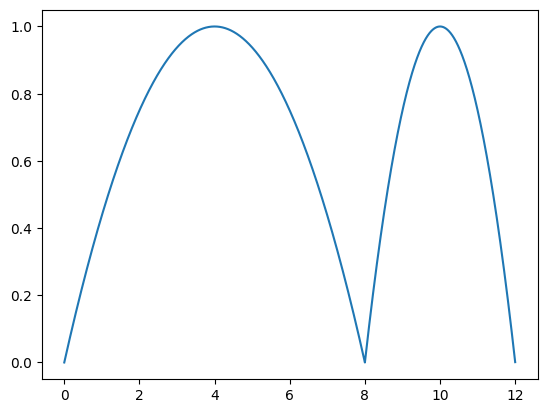

In [22]:
print(x[0][0].values)
plt.plot(x_range, x[0][0].values)

In [23]:
y_ref = y.values.flatten()
print(y_ref.shape)

(100,)


In [24]:
def user_cost_fnc(y, y_hat):
    cost = cp.norm(y - y_hat)
    return cost

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x[:,:,point_idxs].values).reshape((n*n, 2)) / 12
    return points

params = {}
integration_list = ['integration_axis']
params['integration_list'] = integration_list
params['n_points'] = 2
params['epochs'] = 100
params['success'] = 25
params['block_size'] = 100

history = ddq.optimize(x, y_ref / 12, user_cost_fnc, map_func, params, x_sup=None)

INITIAL BLOCK: iteration 0
INITIAL BLOCK: iteration 1
INITIAL BLOCK: iteration 2
INITIAL BLOCK: iteration 3
INITIAL BLOCK: iteration 4
INITIAL BLOCK: iteration 5
INITIAL BLOCK: iteration 6
INITIAL BLOCK: iteration 7
INITIAL BLOCK: iteration 8
INITIAL BLOCK: iteration 9
INITIAL BLOCK: iteration 10
INITIAL BLOCK: iteration 11
INITIAL BLOCK: iteration 12
INITIAL BLOCK: iteration 13
INITIAL BLOCK: iteration 14
INITIAL BLOCK: iteration 15
INITIAL BLOCK: iteration 16
INITIAL BLOCK: iteration 17
INITIAL BLOCK: iteration 18
INITIAL BLOCK: iteration 19
INITIAL BLOCK: iteration 20
INITIAL BLOCK: iteration 21
INITIAL BLOCK: iteration 22
INITIAL BLOCK: iteration 23
INITIAL BLOCK: iteration 24
INITIAL BLOCK: iteration 25
INITIAL BLOCK: iteration 26
INITIAL BLOCK: iteration 27
INITIAL BLOCK: iteration 28
INITIAL BLOCK: iteration 29
INITIAL BLOCK: iteration 30
INITIAL BLOCK: iteration 31
INITIAL BLOCK: iteration 32
INITIAL BLOCK: iteration 33
INITIAL BLOCK: iteration 34
INITIAL BLOCK: iteration 35
IN

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(52, 21)
2.4293815090681583e-09
[[29], [10290]]
[369.1542762    2.72393745]


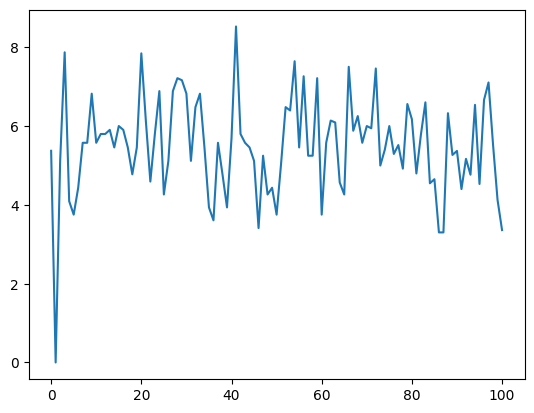

In [25]:
mean_costs = []
for cost in history['cost']:
    mean_costs.append(np.mean(cost))

plt.plot(np.arange(len(mean_costs)), mean_costs)
print(history.keys())
print(history['best'])
print(history['cost'][7][12])
print(history['point_sets'][7][12])
print(history['weight_sets'][7][12])

In [11]:
def user_cost_fnc(y, y_hat):
    cost = cp.norm(y - y_hat)
    return cost

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x[:,:,point_idxs].values).reshape((n*n, 10)) / 12
    return points

params = {}
integration_list = ['integration_axis']
params['integration_list'] = integration_list
params['n_points'] = 10
params['epochs'] = 50
params['success'] = 125
params['block_size'] = 250

history = ddq.optimize(x, y_ref / 12, user_cost_fnc, map_func, params, x_sup=None)

INITIAL BLOCK: iteration 0
INITIAL BLOCK: iteration 1
INITIAL BLOCK: iteration 2
INITIAL BLOCK: iteration 3
INITIAL BLOCK: iteration 4
INITIAL BLOCK: iteration 5
INITIAL BLOCK: iteration 6
INITIAL BLOCK: iteration 7
INITIAL BLOCK: iteration 8
INITIAL BLOCK: iteration 9
INITIAL BLOCK: iteration 10
INITIAL BLOCK: iteration 11
INITIAL BLOCK: iteration 12
INITIAL BLOCK: iteration 13
INITIAL BLOCK: iteration 14
INITIAL BLOCK: iteration 15
INITIAL BLOCK: iteration 16
INITIAL BLOCK: iteration 17
INITIAL BLOCK: iteration 18
INITIAL BLOCK: iteration 19
INITIAL BLOCK: iteration 20
INITIAL BLOCK: iteration 21
INITIAL BLOCK: iteration 22
INITIAL BLOCK: iteration 23
INITIAL BLOCK: iteration 24
INITIAL BLOCK: iteration 25
INITIAL BLOCK: iteration 26
INITIAL BLOCK: iteration 27
INITIAL BLOCK: iteration 28
INITIAL BLOCK: iteration 29
INITIAL BLOCK: iteration 30
INITIAL BLOCK: iteration 31
INITIAL BLOCK: iteration 32
INITIAL BLOCK: iteration 33
INITIAL BLOCK: iteration 34
INITIAL BLOCK: iteration 35
IN

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(52, 21)


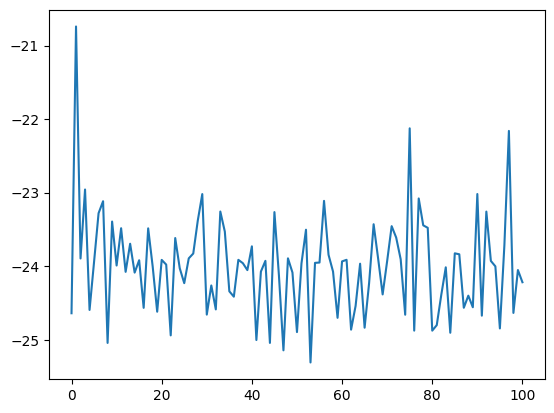

In [29]:
mean_costs = []
for cost in history['cost']:
    mean_costs.append(np.min(cost))

plt.plot(np.arange(len(mean_costs)), np.log(mean_costs))
print(history.keys())
print(history['best'])